In [8]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))

In [9]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from algorithm import *
from explainer import *
from genetic import *
import dalex as dx
from LR import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

In [10]:
data = pd.read_csv('../../../Dataset/Fraudulent_online_shops_dataset.csv')
data['Label'] = data['Label'].replace({'fraudulent': 0, 'legitimate': 1})
data['Presence of free contact emails'] = data['Presence of free contact emails'].replace({2: 1, 3: 1})
data['Indication of young domain '] = data['Indication of young domain '].replace({2: 1})
data.head()

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,Online shop URL,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,...,SSL certificate expire date,Issuer organization,SSL certificate issuer organization list item,Indication of young domain,Domain registration date,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,https://www.allaccessorybest.com,0,24,3,1,0,27,2,0,1,...,Oct 11 03:53:36 2023 GMT,Google Trust Services LLC,9,1,2023-05-15 03:35,0,NaN,0,0,-1
1,https://www.b-watches.shop,0,18,4,1,0,20,2,1,0,...,Jun 16 23:59:59 2024 GMT,"Cloudflare, Inc.",1,1,2023-06-18 05:43,0,NaN,0,0,-1
2,https://www.waeschenamen-windrath.de,1,28,2,1,0,30,2,1,1,...,Oct 24 21:53:20 2023 GMT,Let's Encrypt,2,1,Hidden,0,-1.0,0,0,-1
3,https://vendoprint.se,1,13,2,0,0,17,1,0,1,...,Oct 9 15:13:00 2023 GMT,Google Trust Services LLC,9,1,2022-09-20 00:00,0,-1.0,0,0,-1
4,https://www.newbikeland.com,0,19,3,1,0,22,2,0,1,...,Oct 25 08:20:27 2023 GMT,Let's Encrypt,2,1,2023-07-27 09:05,0,NaN,0,0,-1


In [11]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,Presence of money back payment,...,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,SSL certificate issuer organization list item,Indication of young domain,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,0,24,3,1,0,27,2,0,1,1,...,0,0,0,9,1,0,NaN,0,0,-1
1,0,18,4,1,0,20,2,1,0,1,...,0,1,0,1,1,0,NaN,0,0,-1
2,1,28,2,1,0,30,2,1,1,0,...,0,1,1,2,1,0,-1.0,0,0,-1
3,1,13,2,0,0,17,1,0,1,0,...,0,1,1,9,1,0,-1.0,0,0,-1
4,0,19,3,1,0,22,2,0,1,1,...,0,0,1,2,1,0,NaN,0,0,-1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Label                                          1140 non-null   int64  
 1   Domain length                                  1140 non-null   int64  
 2   Top domain length                              1140 non-null   int64  
 3   Presence of prefix 'www'                       1140 non-null   int64  
 4   Number  of digits                              1140 non-null   int64  
 5   Number  of letters                             1140 non-null   int64  
 6   Number  of dots (.)                            1140 non-null   int64  
 7   Number  of hyphens (-)                         1140 non-null   int64  
 8   Presence of credit card payment                1140 non-null   int64  
 9   Presence of money back payment                 1140 

In [13]:
protected_feature = 'Indication of young domain '

In [31]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='Label',
        protected_feature=protected_feature,
        do_scaling=True,
        scale_all_features=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling ALL numerical features as requested (scale_all_features=True).
Features actually being scaled: ['Domain length', 'Top domain length', 'Number  of digits', 'Number  of hyphens (-)', 'Presence of credit card payment', 'Presence of cash on delivery payment', 'Presence of crypto currency', 'Presence of free contact emails', 'Presence of logo URL', 'Presence of SiteJabber reviews', 'Presence in the standard Tranco list', 'Indication of young domain ']


In [15]:
numerical_features = ['Domain length', 'Top domain length']

In [16]:
print(len(x_train.columns))
x_train.head()

12


,Domain length,Top domain length,Number of digits,Number of hyphens (-),Presence of credit card payment,Presence of cash on delivery payment,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,Presence of SiteJabber reviews,Presence in the standard Tranco list,Indication of young domain
665,-0.319739,-1.147256,0,0,1,0,0,1,1,0,0,0
901,-0.763097,0.175736,1,0,1,1,0,1,1,0,0,0
131,0.788654,0.175736,0,0,0,0,0,0,0,0,0,1
252,-0.098061,0.175736,0,1,0,0,0,1,1,0,0,0
330,1.897047,0.175736,0,0,1,1,0,1,0,0,0,0


In [17]:
feature_names

['Domain length',
 'Top domain length',
 'Number  of digits',
 'Number  of hyphens (-)',
 'Presence of credit card payment',
 'Presence of cash on delivery payment',
 'Presence of crypto currency',
 'Presence of free contact emails',
 'Presence of logo URL',
 'Presence of SiteJabber reviews',
 'Presence in the standard Tranco list',
 'Indication of young domain ']

In [18]:
# Assuming X_train, X_test, y_train, y_test are already separated
# And df is the original DataFrame with its original column names (e.g., 'thalach', 'trestbps', 'chol')

# Define VARIABLES_TO_CHANGE using the original column names
VARIABLES_TO_CHANGE = ['Domain length',
 'Top domain length',
 'Number  of digits',
 'Number  of hyphens (-)',
 'Presence of credit card payment',
 'Presence of cash on delivery payment',
 'Presence of crypto currency',
 'Presence of free contact emails',
 'Presence of logo URL',
 'Presence of SiteJabber reviews',
 'Presence in the standard Tranco list']

# Define the full list of columns you want to select for your features
selected_columns = [protected_feature] + VARIABLES_TO_CHANGE

# Apply the column selection to X_train and X_test
x_train = x_train.loc[:, selected_columns]
x_test = x_test.loc[:, selected_columns]

# y_train and y_test remain unchanged as they already contain the target variable

Accuracy: 0.8830409356725146
Precision: 0.8830409356725146
Recall: 0.8830409356725146
F-1: 0.8830409356725146


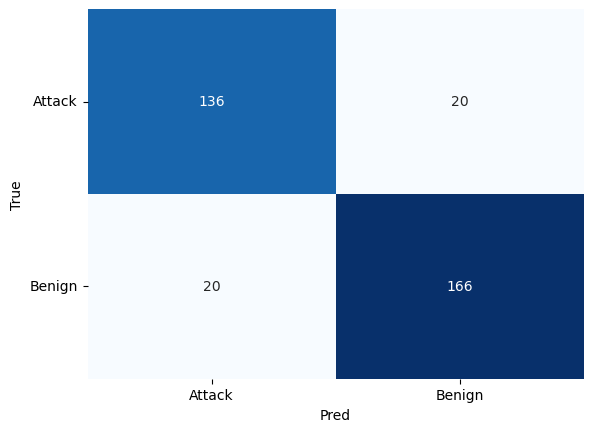

In [19]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [20]:
explainer = Explainer(model, x_test, 'l')

In [21]:
e = dx.Explainer(model, x_test, y_test, verbose=False)
e.model_performance()

,recall,precision,f1,accuracy,auc
LogisticRegression,0.892473,0.892473,0.892473,0.883041,0.949114


In [22]:
# pd.DataFrame({'variable': x_train.columns, 'importance_split': model.feature_importances_,
#               'importance_shap': explainer.shap_values(explainer.data),
#               'importance_perm': e.model_parts(B=25).result.sort_values("variable").iloc[2::,:].dropout_loss})


In [23]:
I = 106
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I)
e.data.iloc[[I]].assign(y=e.y[[I]], y_hat=e.y_hat[[I]])

,Indication of young domain,Domain length,Top domain length,Number of digits,Number of hyphens (-),Presence of credit card payment,Presence of cash on delivery payment,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,Presence of SiteJabber reviews,Presence in the standard Tranco list,y,y_hat
937,0,-0.098061,0.175736,0,0,1,0,0,1,1,1,0,1,0.990443


In [24]:
print(a._x.shape, a._X.shape)

(12,) (342, 12)


In [25]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
print(a._X.shape, a._x.shape)
t = a.explainer.shap_values(a._X)
print(t)
t = np.array([i + (t[0] / (len(t) - 3)) if i > 0 else i - (t[0] / (len(t) - 3)) for i in t])
t[0] = -0.05
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X), 'target': t})

(342, 12) (12,)
[1.73103692 0.36426546 0.53917478 0.00676065 0.17277425 0.27954248
 0.5078816  0.05267038 1.2178468  0.39658431 0.16991641 0.00924042]


,variable,shap_values,target
0,Indication of young domain,1.731037,-0.050000
1,Domain length,0.364265,0.556603
2,Top domain length,0.539175,0.731512
3,Number of digits,0.006761,0.199098
4,Number of hyphens (-),0.172774,0.365112
5,Presence of credit card payment,0.279542,0.471880
6,Presence of cash on delivery payment,0.507882,0.700219
7,Presence of crypto currency,0.052670,0.245008
8,Presence of free contact emails,1.217847,1.410184
9,Presence of logo URL,0.396584,0.588922


In [26]:
t.shape

(12,)

In [27]:
a.fool_aim(target=np.array(t), max_iter=500, random_state=0)

  0%|          | 0/500 [00:00<?, ?it/s]

Iter: 500 || Loss: 0.46753325083113656: 100%|██████████| 500/500 [13:43<00:00,  1.65s/it]


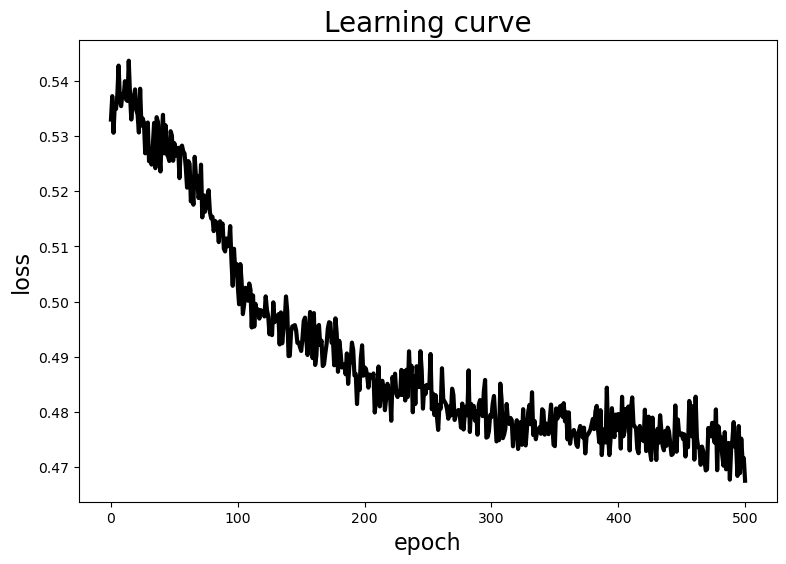

In [28]:
a.plot_losses()

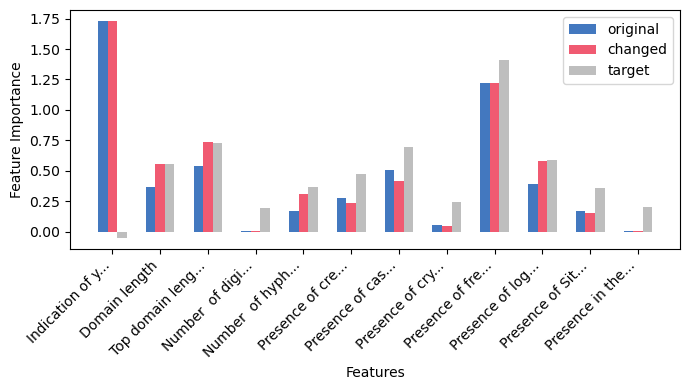

In [29]:
a.plot_explanation()

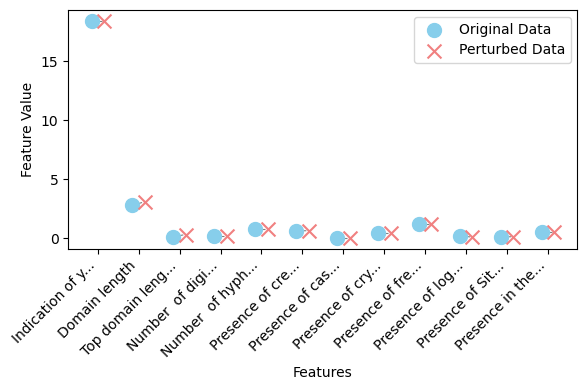

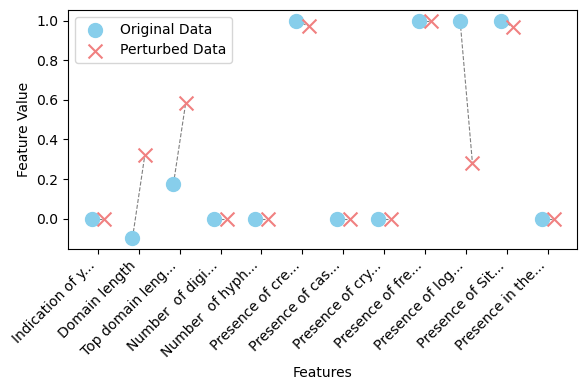

In [32]:
a.plot_data(scaler=scaler, numerical_features_scaled=VARIABLES_TO_CHANGE)
a.plot_data()

In [33]:
a.display_feature_rank_changes()


--- Feature Ranking Changes ---

Ranking Changes: Original vs. Changed Explanation
--------------------------------------------------
Feature 'Presence of cash on delivery payment': Rank changed from 4 to 6
Feature 'Presence of logo URL': Rank changed from 5 to 4
Feature 'Domain length': Rank changed from 6 to 5
Feature 'Presence of credit card payment': Rank changed from 7 to 8
Feature 'Number  of hyphens (-)': Rank changed from 8 to 7

Table Summary (Original vs. Changed):
                             Feature  Rank_Original  Rank_Changed
Presence of cash on delivery payment              4             6
                Presence of logo URL              5             4
                       Domain length              6             5
     Presence of credit card payment              7             8
              Number  of hyphens (-)              8             7


Ranking Changes: Original vs. Target Explanation
--------------------------------------------------
Feature 'Indication o

In [ ]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X)
# print(t)
t = np.array([i*0+np.mean(t)*2.75 for i in t])
# t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X), 'target': t})

,variable,shap_values,target
0,Indication of young domain,1.731037,1.24843
1,Domain length,0.364265,1.24843
2,Top domain length,0.539175,1.24843
3,Number of digits,0.006761,1.24843
4,Number of hyphens (-),0.172774,1.24843
5,Presence of credit card payment,0.279542,1.24843
6,Presence of cash on delivery payment,0.507882,1.24843
7,Presence of crypto currency,0.052670,1.24843
8,Presence of free contact emails,1.217847,1.24843
9,Presence of logo URL,0.396584,1.24843


In [ ]:
a.fool_aim(target=np.array(t), max_iter=100, random_state=0)

Iter: 100 || Loss: 0.5448509584365495: 100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


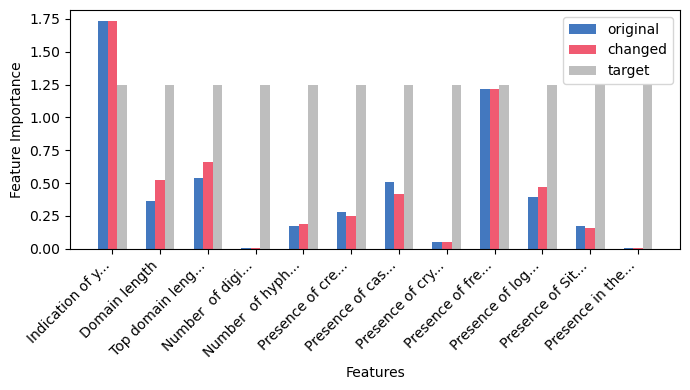

In [ ]:
a.plot_explanation()

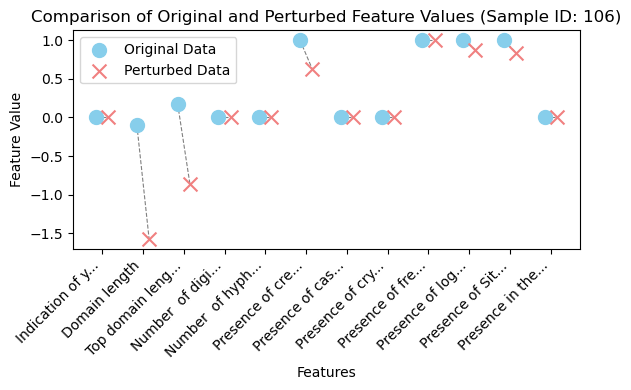

In [ ]:
a.plot_data(scaler=scaler, numerical_features_scaled=VARIABLES_TO_CHANGE)
a.plot_data()

In [ ]:
a.display_feature_rank_changes()